# Introduction
This notebook contains a comprehensive analysis of a Raman spectroscopy data set collected during a Tangential Flow Filtration (TFF) process. The objective of this analysis is to explore, preprocess, and model the spectral data using [**chemometric techniques**](https://en.wikipedia.org/wiki/Chemometrics) implemented in Python. Initially, spectral preprocessing methods such as noise reduction, normalisation techniques, and baseline correction were applied to the spectra. This was followed by PLS Regression modelling to extract concentration data from the spectra collected during an experimental process run.
### What is Raman Spectroscopy?
Raman Spectroscopy is an analytical technique widely used in chemistry, biology, and materials science to identify and quantify different compounds in a sample. By using laser light to detect molecular vibrations, Raman spectroscopy generates spectral data that can be analyzed using chemometric techniques to reveal concentrations and molecular information.
### What is TFF? 
TFF stands for Tangential Flow Filtration, a filtration process used to separate and purify biomolecules such as proteins. Unlike traditional filtration where the fluid passes directly through the membrane and the filtrate is collected in a batch, TFF allows the fluid to flow tangentially across the membrane, enabling continuous filtration. TFF is commonly used in biopharmaceutical production to concentrate or purify solutions.

In this project, the TFF setup incorporates an online Raman flow cell to monitor the retentate concentration in real time as a solution of immunoglobin (IgG 1) passes through the filtration membrane. The initial solution starts with an immunoglobulin concentration of 1 mg/mL, and TFF is used to concentrate the solution up to 10 mg/mL. The online Raman cell monitors the concentration of the retentate in real time to track protein concentration during the filtration, and detect the end point of the process. Below is a process flow diagram of the TFF process. 
<br>
<div align="center" style="background-color: white; width: fit-content; margin: auto;">
    <img src=".\img\tff_pfd.png" alt="PFD of TFF" height="350">
</div>

****************
### Overview of Notebook Contents
****************

- `chemometrics_analysis_script.py` python script is imported at the start of the notebook. 
- The functions used throughout this notebook for visualizing data and performing various data handling, manipulation, preprocessing, and statistical modeling tasks are defined in the script. 

<br> 

1. **Data Visualisation**
    - The raw spectra were plotted.
2. **Spectral Preprocessing**
    - Noise was reduced, intensity normalized, the baseline corrected, and the key peak isolated to prepare the spectra for analysis and modeling.
3. **Model Training and Application**
    - A PLS Regression model was trained on reference data to predict concentrations in experimental data. 

# 1. Data Visualisation
- The spectral data was plotted to verify correct reading of the raw data. 
- This Matplotlib resource on [how to choose appropriate colour maps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#sphx-glr-users-explain-colors-colormaps-py)  were helpful in choosing effective, perceptually uniform colormaps for the data.
- I used these matplotlib tutorials on [creating customized colorbars](https://matplotlib.org/stable/users/explain/colors/colorbar_only.html) and [adjusting colormaps](https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html#creating-colormaps-in-matplotlib) to define appropriate color steps in the colormaps for effective data representation.  
- A combined plot of reference and experimental spectra was created, requiring separate legends to distinguish between concentration and time-based data. The following resources were used when creating the legend:  
    - [Creating proxy artists](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists)
    - [Controlling the legend entries](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries)
    - [Adding multiple legends to same axis](https://matplotlib.org/stable/users/explain/axes/legend_guide.html#multiple-legends-on-the-same-axes)
    - [Chapter in *Python for Datascience* on legend formatting](https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html#Multiple-Legends)

In [1]:
import chemometric_analysis_script

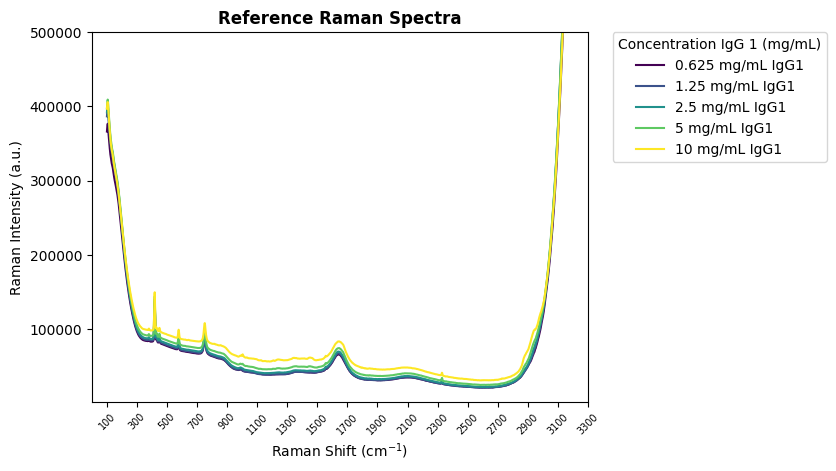

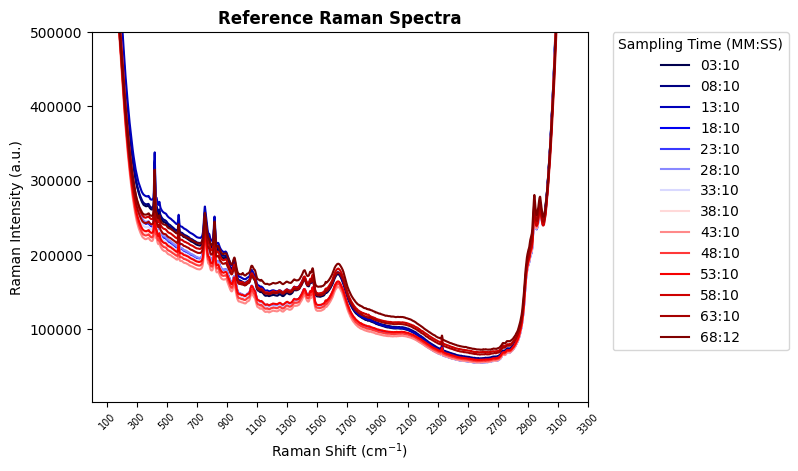

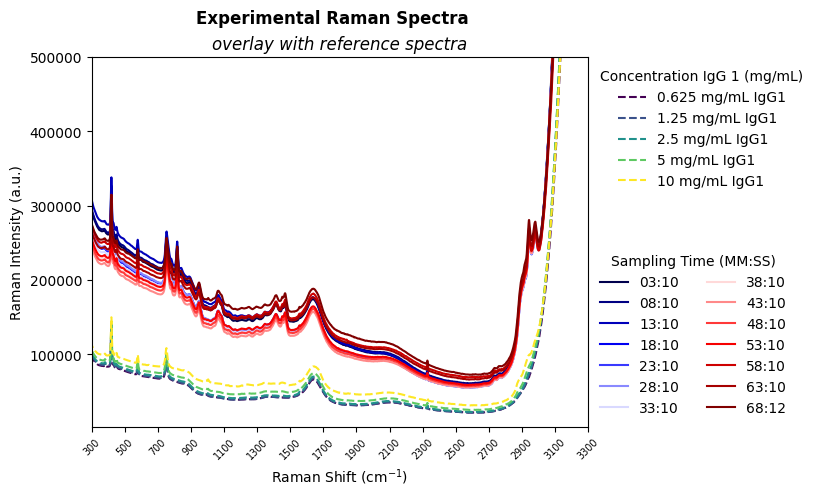

In [2]:
chemometric_analysis_script.plot_raw_spectra(chemometric_analysis_script.reference_raman_spectra, chemometric_analysis_script.purple_colors) 
chemometric_analysis_script.plot_raw_spectra(chemometric_analysis_script.experimental_raman_spectra, chemometric_analysis_script.red_colors)
chemometric_analysis_script.plot_overlaid_spectra(chemometric_analysis_script.reference_raman_spectra, chemometric_analysis_script.purple_colors, chemometric_analysis_script.experimental_raman_spectra, chemometric_analysis_script.red_colors)

# 2. Spectral Preprocessing
- **Spectral Preprocessing** refers to a series of techniques and transformations applied to raw spectral data in order to make it suitable for subsequent analysis and modeling.
- The main objectives of spectral preprocessing include:
    - Noise reduction
    - Normalisation (scaling)
    - Baseline correction
    - Peak identification
- The preprocessing methods used and hyperparameters applied depend heavily on the specific characteristics of the data. 
- [**Rinnan, Åsmund, et al. (2009) Data Pre-Processing**](https://www.researchgate.net/publication/277889759_Data_Pre-Processing) provides an overview of the available spectral preprocessing techniques and their application. 
- This article from Medium on [Data Science for Raman Spectroscopy](https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f) outlines the application of these presprocessing steps though Python, with an associated [Jupyter notebook](https://github.com/nicocopez/Data-Science-for-Raman-spectroscopy-a-practical-example/blob/main/Workshop%20ML%20with%20Python%20-%20DS%20for%20Raman%20spectroscopy%20-%20An%20example%20by%20NCL.ipynb).  
- The preprocessing steps applied to the Raman spectroscopy data in this project are outlined below:
    1. **Smoothing and Normalization:** A first derivative was applied to the spectra and the Raman intensity was normalised across the spectra.
    2. **Baseline Correction:** The Asymmetric Least Squares (APLS) algorithm wass used to correct for baseline variations.
    3. **Peak Identification:** The spectral region associated with the concentrated of IgG 1 was identified in the preprocessed (first derivative, normalized, and baseline-corrected)     spectra.
    4. **Final Baseline Correction:** A final baseline correction was applied, specifically targeting the region of interest in the spectra.

### 2.1 Data Smoothing and Normalisation  

- **Data Smoothing:** 
- The Savistky-Golay filter in Scipy was used to smooth the data by applying the first derivative.  
- Some more information on the implementation of this method can be found in this article by [Nirpy Research on the application of the Savitzky–Golay smoothing method](https://nirpyresearch.com/savitzky-golay-smoothing-method/).

- **Normalisation/ Scaling**
- Three separate scaling techniques were applied to the smoothed data: min-max, max absolute, and SNV. 
- A function was defined in the chemometric analysis script that applied the Savistky-Golay filter, followed by a scaler to the data. 
- A nested for loop then applied each scaling method to each of the two data sets (reference and experimental) and saved the results to a dictionary: 

``````
def normalised_first_derivative(dataframe, scaler):  
    first_der = savgol_filter(np.array(dataframe), window_length=5, delta=dataframe.index[1] - dataframe.index[0], polyorder=3)
    scaled_spectra = scaler.fit_transform(first_der)
    return scaled_spectra

scaled_data = {} #initialise an empty dictionary to save the scaled data to
# Iterate over scalers and spectra to populate the scaled_data dictionary
for scaler, scaler_name in zip([preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), preprocessing.MaxAbsScaler()], ["SNV", "minmax", "maxabs"]):
    for spectra, spectra_name in zip([reference_raman_spectra, experimental_raman_spectra], ['reference', 'experimental']):
        scaled_spectra = normalised_first_derivative(spectra, scaler)
        key_name = f"{scaler_name}_scaled_{spectra_name}_spectra" 
        scaled_data[key_name] = scaled_spectra
``````

- The scaling results were plotted together to identify the most effective approach, as shown below.  
- This [Medium article](https://medium.com/@chrisjpulliam/standard-normal-variate-snv-signal-processing-for-near-ir-data-f9bb7a96a42d) provides a detailed explanation of SNV normalization, which was selected for the final dataset used in model building.
- The following documentation from scikit learn on their preprocessing tools was used: 
    - [User guide on spectral preprocessing with scikit-learn](https://scikit-learn.org/1.5/modules/preprocessing.html)
    - [A comparison of different scaling methods](https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
    - [Importance of Feature Scaling](https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

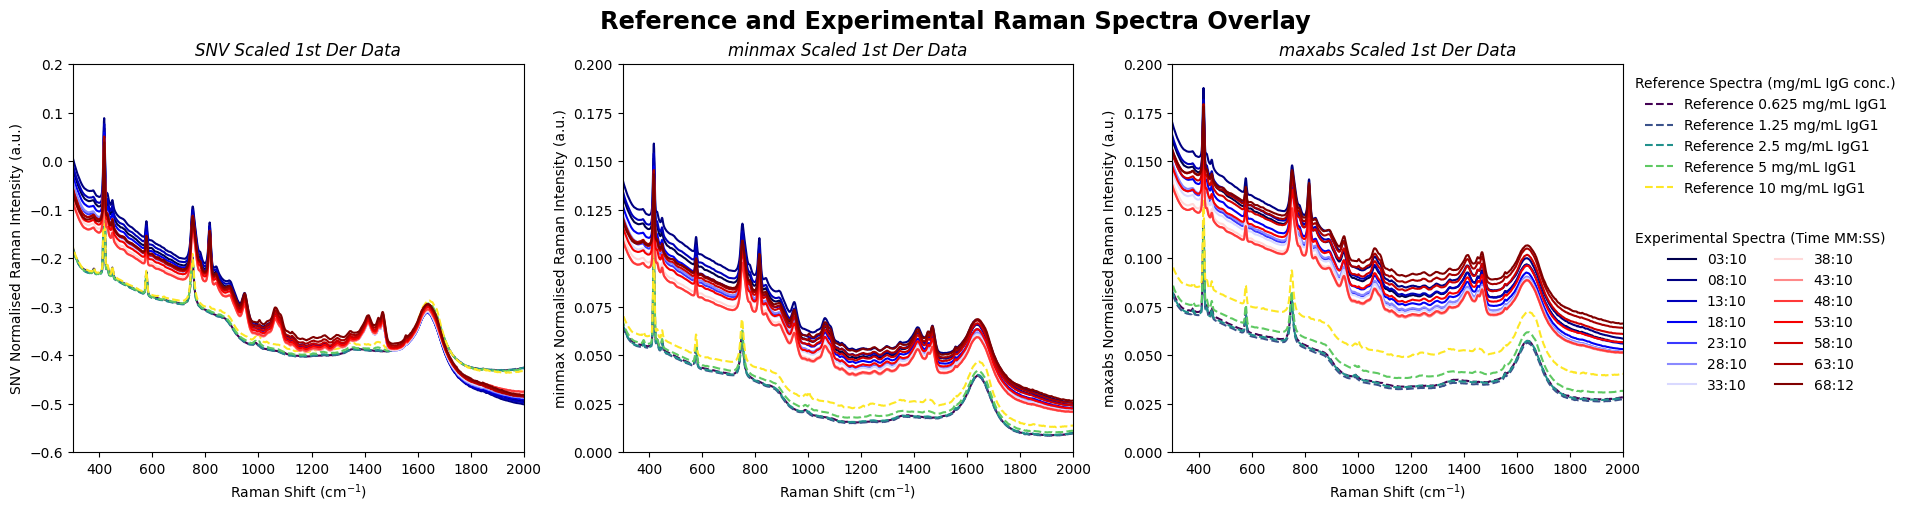

In [7]:
chemometric_analysis_script.plot_normalisation_techniques()

### 2.2 Baseline Correction
- After choosing an appropriate scaling technique, it was necessary to correct the Raman sepctra baseline. 
- A number of different baseline corrections algorithm can be applied, and their use depends on the spectra. 
- For the spectra being analysed in this data set, the ALS algorithm for baseline correction was most appropriate. 
- The references used for baseline correction are outlined below: 
    - [Medium Article: Data Science for Raman Spectroscopy: A Practical Example](https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f)
    - [Nirpy research article on two different types of baseline correction](https://nirpyresearch.com/two-methods-baseline-correction-spectral-data/)
    - [Stackoverflow discussion on best baseline correction methods with Python](https://stackoverflow.com/questions/29156532/python-baseline-correction-library)

- The [Algorithm for ALS baseline correction](https://irfpy.irf.se/projects/ica/_modules/irfpy/ica/baseline.html) is applied to the spectra. 
- This defines a corrected baseline which can then be subtracted from the original spectra to give the baseline corrected spectra. 
````
def als(y, lam=1e6, p=0.1, itermax=10): #This function computes the baseline to be subtracted from the original spectra
    L = len(y)
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z
def subtract_als_baseline(scaler_name, spectra_name): #This function subtracts the als basleine computed in the als algorithm above
    spectra=scaled_data[f"{scaler_name}_scaled_{spectra_name}_spectra"] #This extracts the data from the dictoinary 
    als_baseline = np.array([als(spectra[:, i]) for i in range(spectra.shape[1])]).T #For each spectra, extract the baseline defined by the als algorithm 
    return(spectra-als_baseline)
````
*********************************
**The baseline corrected spectra are plotted overlaid with the original spectra below:**

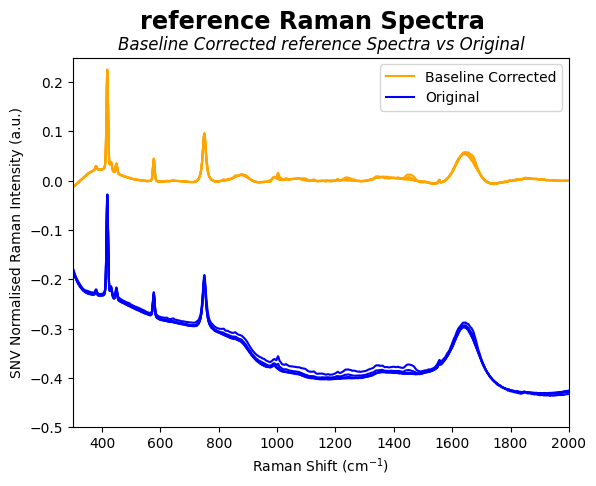

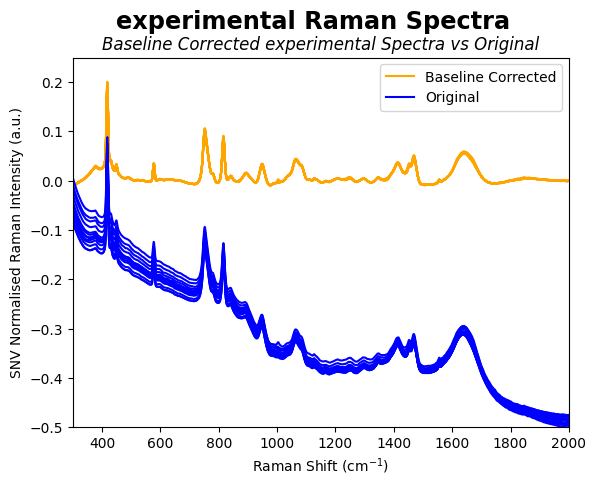

In [3]:
chemometric_analysis_script.plot_baseline_corrected_spectra("SNV","reference")
chemometric_analysis_script.plot_baseline_corrected_spectra("SNV","experimental")

### 2.3 Peak Identification
- In order to identify the area of the spectra that was changing with immunoglobin concentration, a function that takes the wavenumbers as an argument and plots only that region of the spectra was defined:  
````
#4: Identify peak/ region of interest in spectra:
def plot_peak_of_interest(dataframe_1, dataframe_2, xlim, ylim):
    fig, ax = plt.subplots()

    for i, column in enumerate(dataframe_1.columns):
        ax.plot(
            dataframe_1.index,
            (subtract_als_baseline("SNV","reference")).T[i],
            label=column,
            color=purple_colors[i],
            linestyle="--"
        )
    for i, column in enumerate(dataframe_2.columns):
        ax.plot(
            dataframe_2.index,
            (subtract_als_baseline("SNV","experimental")).T[i],
            label=column,
            color=red_colors[i]
        )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'Raman Shift (cm$^{-1})$')
    ax.set_ylabel("Raman Intensity (a.u.)")
    ax.set_title(f"overlay with reference spectra",
                fontdict = {'fontsize': 'large','fontstyle' : "italic",}
                )
    fig.suptitle(f"Experimental Raman Spectra",
                fontweight="bold"
                )
    #Generate the legends: 
    handles, labels = ax.get_legend_handles_labels()
    legend_2= ax.legend(handles[len(dataframe_1.columns):], 
                        labels[len(dataframe_1.columns):],
                        title=dataframe_2.columns.name,
                        ncols=2,
                        loc="upper left",
                        bbox_to_anchor=(1, 0.5),
                        frameon=False
                        )
    ax.add_artist(legend_2)
    ax.legend(handles[0:len(dataframe_1.columns)], 
                labels[0:len(dataframe_1.columns)],
                title=dataframe_1.columns.name,
                loc="upper left",
                bbox_to_anchor=(1, 1),
                frameon=False
            )
````
- Through zooming into various areas of the spectra, a peak at 996 - 1015 cm<sup>-1</sup> was identified that changed with concentration. 


### 2.4 Final Baseline Correction
- After extracting the peak of interest (996 - 1015 cm <sup>-1</sup>), a final baseline correction step was applied to that region of the spectra before building the PLS Regression model. 
- This involved finding the minimum intensity of the spectra in that region and subtracting it. 
- This aligns the entire spectrum such that its lowest point touches zero. 
*********************************
**The peak of interest is plotted below:**

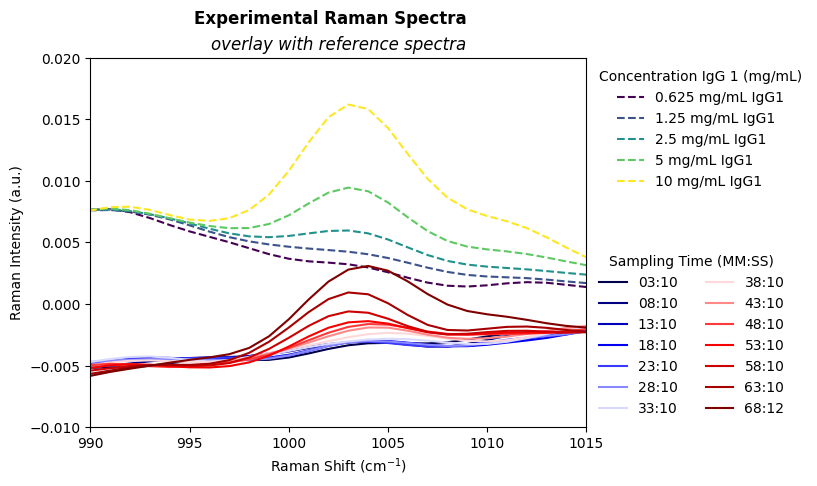

In [4]:
chemometric_analysis_script.plot_peak_of_interest(chemometric_analysis_script.reference_raman_spectra, chemometric_analysis_script.experimental_raman_spectra, (990,1015), (-0.01,0.02))

# 3. Model Training and Application
- A **Partial Least Squares regression model** was built to predict the concentration of immunoglobin in each sample in the experimental data set. 
- This paper, [An Introduction to Partial Least Squares Regression Randall D. Tobias, SAS Institute Inc., Cary, NC](https://stats.oarc.ucla.edu/wp-content/uploads/2016/02/pls.pdf), contains the following description of when PLS can be used in place of a simpler multiple linear regression model.  
    - *Partial least squares (PLS) is a method for constructing predictive models when the factors are many and highly collinear.*
    - *In principle, MLR can be used with very many factors. However, if the number of factors gets too large (for example, greater than the number of observations), you are likely to get a model that fits the sampled data perfectly but that will fail to predict new data well. This phenomenon is called over-fitting.* 
- Analysis in a univariate or bivariate manner often cannot capture interactions occuring between variables that might be contributing to variation in the data. In order to appropriately analyze the entire data set, multivariate analysis through PLS is necessary when analysing spectral data.
- PLS reduces the dimensions of the data set by transforming them into a smaller set of variables (known as principal components) that still contain most of the information in the data set.
    - A principal component is a linear combination of the original set of variables.
    - In this way, a data set is created where most of the information contained in this large set of variables is captured in only 2-3 variables, which is much easier to visualise and analyse. 

**References used for PLS Regression:**
- This video, [Introduction to PLS-DA](https://www.youtube.com/watch?v=cupvyzS0n38&t=855s) on Youtube, explains PLS classification clearly and simply. Although we are not doing a classification PLS, we are doing a regression analysis, this video has good visuals that were helpful to me in understanding the variable reduction. 
- [A study of PLS Methods by Jacob A. Wegelin](https://stat.uw.edu/sites/default/files/files/reports/2000/tr371.pdf) is a detailed paper explaining the application of various PLS methods, with a particular emphasis on the two-block case. Although not used in this model, the two-block case (W2A algorithm), is common in spectral analysis as it assigns weightings to spectral regions particularly associated with the response being measured. 
- This [Learn Data article on PLS](https://learndataa.com/2021/04/30/partial-least-squares-pls-w2a-algorithm/) shows the implementation of the PLS-W2A algorithm in Python using the source code from Scikit-learn docs. There are two associatied Youtubes videos with the article that go through the linked notebook in detail.
    - This [Learn Data Youtube video](https://www.youtube.com/watch?v=QgJp0otqeGM) in particular uses Scikit Learn PLS modelling to perform Chemometrics on N-IR spectra, to determine the amylose content in rice. The associated Jupyter notebook can be found [here](https://github.com/learndataa/projects/blob/main/i80_sk77_SL_55__project__Spectroscopy_Chemometrics.ipynb).
    - **Citation**: [P. Sampaio, A. Soares, A. Castanho, A.S. Almeida, J. Oliveira, C. Brites, Dataset of Near-infrared spectroscopy measurement for amylose determination using PLS algorithms, Volume 15, 2017, Pages 389-396, ISSN 2352-3409](https://doi.org/10.1016/j.dib.2017.09.077)
- The documentation and tutorials available from scikit learn were also very helpful:
    -  [scikit learn Cross Decomposition](https://scikit-learn.org/stable/modules/cross_decomposition.html)
    - [scikit learn PCR vs. PLS](https://scikit-learn.org/stable/modules/cross_decomposition.html)

- The PLS model, trained on the reference data, is outlined below: 

````
pls_model=PLSRegression(n_components=n)
pls_model=pls_model.fit(x_train, y_train)
````

**Cross Validation** was used to assess the performance of the model. 
- Cross validation is used to gauge the accuracy of a supervised machine learning model, which is what this model is since it is trained on labelled data (the reference spectra) and subsequently used to predict unknown data (the experimental spectra). 
- In cross validation, the training data is split into subsets. The model is trained on some subsets and tested on the remaining data to ensure it generalizes well to unseen data.  
- This [scikit learn aritcle](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) on cross validation explains that:
    - *Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set.* 
- However, since we have 5 samples only for reference, we drastically reduce the number of samples which can be used for training the model through holding out a number of samples as a test set, and with so few samples the results can depend on a particular random choice for the pair of (train, validation) sets.
- In this instance, cross validation is a better option as it provides a better estimate of model accuracy than a single train-test split, reducing the risk of overfitting or underfitting.
- **Leave One Out cross validation** (LOOCV) is a specific type of cross-validation where, for $n$  samples, the model is trained on $n−1$ samples and tested on the one sample left out. 
    - The model runs the same number of iterations as there are samples.
    - For each iteration, it leaves one sample out, trains on the remaining samples, and tests on the sample left out of the training set.
    - It is good for small training sets as it maximises the data the model is  being trained on before testing. In this case that means each iteration gets     to train on 4 samples. 
    - The only reason not to use LOOCV is that is is computationally expensive,     for a large data set, as it runs so many iterations. Since our reference data   only contains 5 samples, LOOCV is the correct approach to take. 

````
score = sklearn.model_selection.cross_val_score(estimator=pls_model, X=x_train, y=y_train, cv=LeaveOneOut(), scoring=make_scorer(mean_squared_error)) 
performance = (f"Model performance:\n Average MSE: {score.mean():.2f}\n Standard Deviation: {score.std():.2f}")
y_pred = cross_val_predict(estimator=pls_model, X=x_train, y=y_train, cv=LeaveOneOut())
````


- After training the model, and assessing its performance metrics, the model was then used to predict the concentration of immunoglobin in each sample in the experimental data set. 
````
y_pred_exp=pls_model.predict(x_exp)
````
************
**The model performance and predictions are graphed below:**

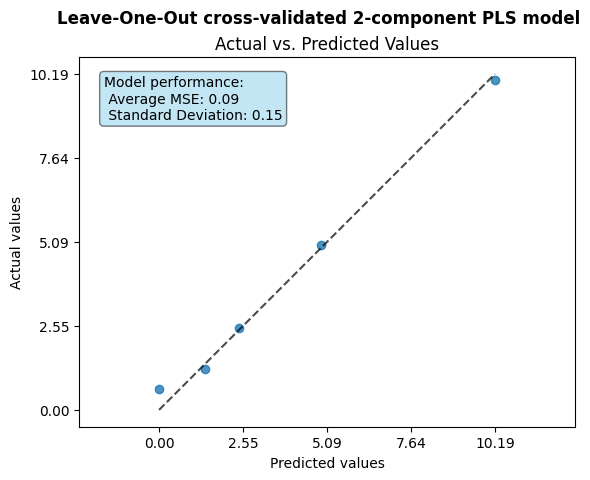

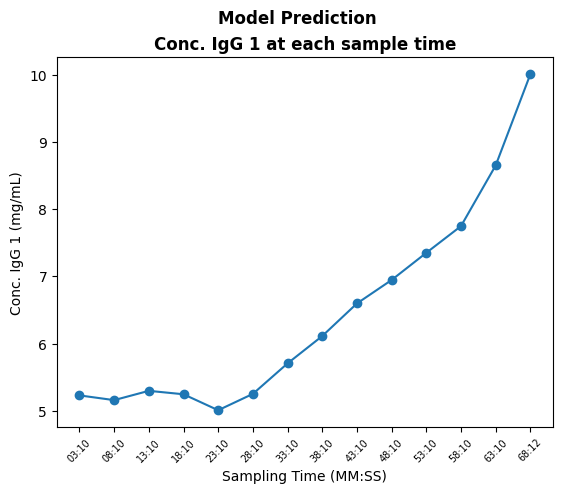

In [ ]:
chemometric_analysis_script.train_plsr_model(chemometric_analysis_script.x_train, chemometric_analysis_script.y_train, n=2)

**************

# **END**
